In [2]:
import os
import glob
import numpy as np
import trimesh
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from time import time
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

In [3]:
data_dir = r'/ocean/projects/mch210006p/mhrahman/Main/'
mesh = trimesh.load(os.path.join(data_dir,'Cylindrical_pins/train/00019264.obj'))
mesh.show()

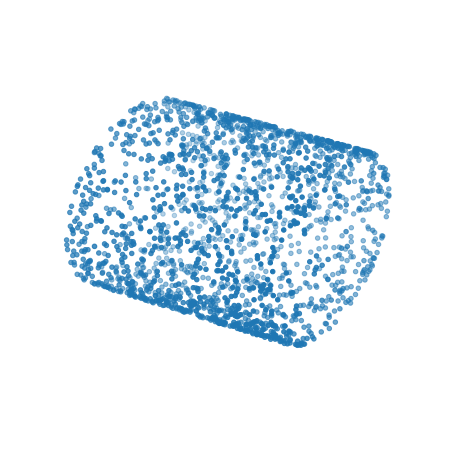

In [4]:
points = mesh.sample(2048)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(points[:,0],points[:,1],points[:,2])
ax.set_axis_off()
plt.savefig('/jet/home/mhrahman/Projects/Project/Pointnet/Figures/Point.jpg',dpi = 300)
plt.show()

In [4]:
folders = glob.glob(os.path.join(data_dir,'*'))
len(folders)

67

In [5]:
def parse_dataset(num_point = 2048):
    train_points = []
    train_labels = []
    val_points = []
    val_labels = []
    test_points = []
    test_labels =[]
    class_map = {}
    folders = glob.glob(os.path.join(data_dir,'*'))
    
    for i, folder in enumerate(folders):
        print("processing class {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        train_files = glob.glob(os.path.join(folder,"train/*obj"))
        val_files = glob.glob(os.path.join(folder,"val/*obj"))
        test_files = glob.glob(os.path.join(folder,"test/*obj"))
        
        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_point))
            train_labels.append(i)
        for f in val_files:
            val_points.append(trimesh.load(f).sample(num_point))
            val_labels.append(i)
        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_point))
            test_labels.append(i)
    return(
    np.array(train_points),
    np.array(val_points),
    np.array(test_points),
    np.array(train_labels),
    np.array(val_labels),
    np.array(test_labels),
    class_map
    )

In [6]:
NUM_POINTS = 2048
NUM_CLASSES = 67
BATCH_SIZE = 32
train_points, val_points, test_points, train_labels, val_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class Bushes
processing class Grooved_pins
processing class Thrust_washers
processing class Tapping_screws
processing class Hook
processing class Rivet_nut
processing class Lever
processing class Wingnuts
processing class Turbine
processing class Springs
processing class Flanged_plain_bearings
processing class Split_pins
processing class Screws_and_bolts_with_countersunk_head
processing class Helical_geared_motors
processing class Clamps
processing class T_shape_fitting
processing class Square_nuts
processing class Locknuts
processing class Plates_circulate_plates
processing class Plain_guidings
processing class Bearing_accessories
processing class Setscrew
processing class Cylindrical_pins
processing class T_nut
processing class Studs
processing class Socket
processing class Chain_drives
processing class Fan
processing class Standard_fitting
processing class Wheel
processing class Square
processing class Articulations_eyelets_and_other_articulated_joints
processing class Va

In [7]:
def augment(points, labels):
    points += tf.random.uniform(points.shape,-.005,0.005,dtype=tf.float64)
    points = tf.random.shuffle(points)
    return points, labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_points,train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_points,val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points,test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(len(val_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [8]:
def conv_bn(x,filters):
    x = layers.Conv1D(filters,kernel_size=1,padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)
def dense_bn(x,filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [9]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self,num_features,l2reg = 0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)
    def __call__(self,x):
        x = tf.reshape(x,(-1,self.num_features,self.num_features))
        xxt = tf.tensordot(x,x,axes=(2,2))
        xxt = tf.reshape(xxt,(-1,self.num_features,self.num_features))
        return tf.reduce_sum(self.l2reg*tf.square(xxt - self.eye))

In [10]:
def tnet(inputs,num_features):
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    
    x = conv_bn(inputs,64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x,512)
    x = dense_bn(x,256)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer= 'zeros',
        bias_initializer=bias,
    activity_regularizer= reg)(x)
    feat_T = layers.Reshape((num_features,num_features))(x)
    return layers.Dot(axes=(2,1))([inputs,feat_T])

In [11]:
inputs = keras.Input(shape=(NUM_POINTS,3))

x = tnet(inputs,3)
x = conv_bn(x,64)
x = conv_bn(x,64)
x = tnet(x,64)
x = conv_bn(x,64)
x = conv_bn(x,128)
x = conv_bn(x,1024)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x , 512)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = "pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2048, 64)     256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2048, 64)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [ ]:
class TimeCallback(Callback):
    def on_train_begin(self,logs={}):
        self.logs=[]
    def on_epoch_begin(self,epoch,logs={}):
        self.starttime = time()
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(time()-self.starttime)
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience = 20,min_delta = 1)
cb = TimeCallback()
checkpoints = ModelCheckpoint('weight.hdf5',monitor='sparse_categorical_accuracy',verbose=1,save_best_only= True,mode='max')

In [ ]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"])

In [ ]:
model_history = model.fit(train_dataset, epochs=100, validation_data= val_dataset,callbacks = [es,cb])
model.save_weights('weight_2.h5')

In [ ]:
#plot training and validation curve
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r')
plt.plot(epochs,val_acc,'b')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.savefig('/jet/home/mhrahman/Projects/Project/Pointnet/Figures/Classification_acc.jpg',dpi = 300)
plt.show()


plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(["Training loss","Validation loss"])
plt.savefig('/jet/home/mhrahman/Projects/Project/Pointnet/Figures/Classification_loss.jpg',dpi = 300)
plt.show()

In [12]:
model.load_weights('weight_2.h5')

In [29]:
y_actual = np.concatenate([y for x, y in test_dataset], axis = 0)
y_actual

array([22, 24, 24, ..., 12, 42, 13])

In [47]:
data = test_dataset.take(5)
point, label = list(data)[0]

In [13]:
y_pred = model.predict(test_points)

In [14]:
y_pred = tf.argmax(y_pred, axis = 1)
y_pred

<tf.Tensor: id=3736, shape=(5224,), dtype=int64, numpy=array([ 0,  0,  0, ...,  2, 66, 66])>

In [15]:
Classes = list(CLASS_MAP.values())

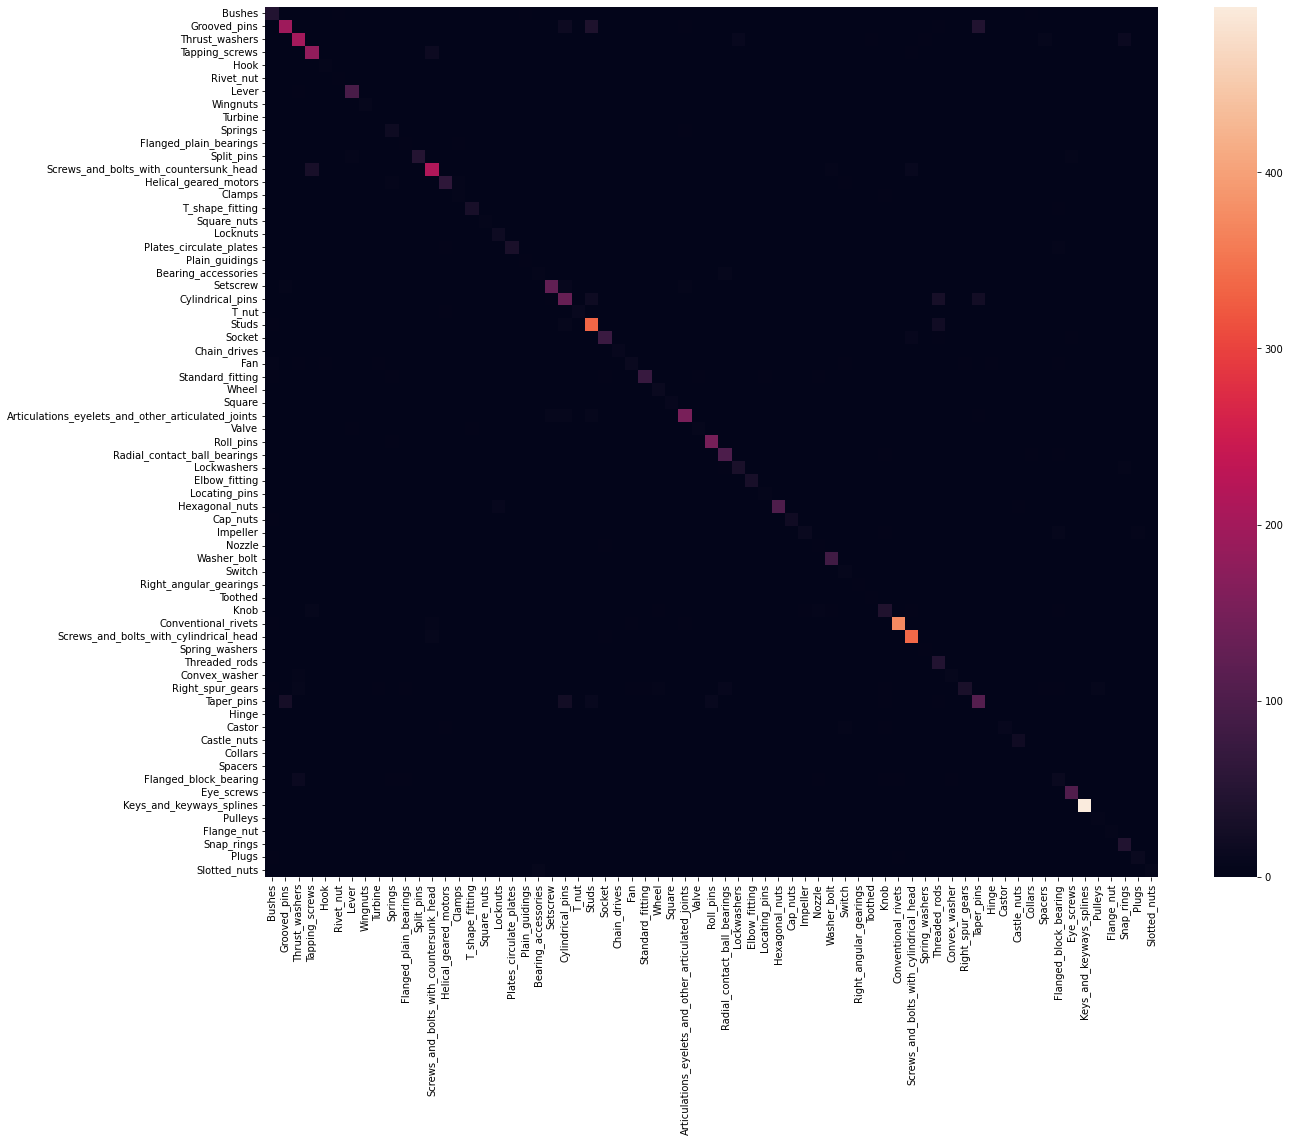

In [28]:
conf = confusion_matrix(y_pred,test_labels)
df = pd.DataFrame(conf,index=Classes,columns=Classes)
plt.figure(figsize=(20,16))
sns.heatmap(df,annot= False)
plt.savefig(r'/jet/home/mhrahman/Projects/Project/Pointnet/Figures/Heat.jpg', dpi = 300)
plt.show()

In [18]:
class_report = classification_report(y_pred,test_labels,output_dict=True)
report_df = pd.DataFrame(class_report).transpose()
report_df.to_csv('Report.csv')

/jet/home/mhrahman/ML/Project/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
report_df

,precision,recall,f1-score,support
0,0.615385,0.750000,0.676056,64.000000
1,0.857778,0.647651,0.738050,298.000000
2,0.871795,0.819277,0.844720,249.000000
3,0.826484,0.896040,0.859857,202.000000
4,0.384615,0.714286,0.500000,7.000000
...,...,...,...,...
65,0.666667,0.631579,0.648649,19.000000
66,0.666667,0.428571,0.521739,14.000000
accuracy,0.829058,0.829058,0.829058,0.829058
macro avg,0.663629,0.705924,0.660850,5224.000000


In [16]:
y_score = tf.keras.utils.to_categorical(y_pred,len(Classes))

In [17]:
y_test = tf.keras.utils.to_categorical(test_labels,len(Classes))

In [18]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(Classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:,i],y_score[:,i])
    average_precision[i] = average_precision_score(y_test[:,i],y_score[:,i])
precision["micro"], recall["micro"],_ = precision_recall_curve(y_test.ravel(),y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

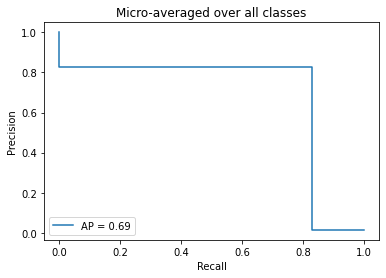

In [19]:
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")
plt.savefig(r'/jet/home/mhrahman/Projects/Project/Pointnet/Figures/Pr_Re.jpg', dpi = 300)

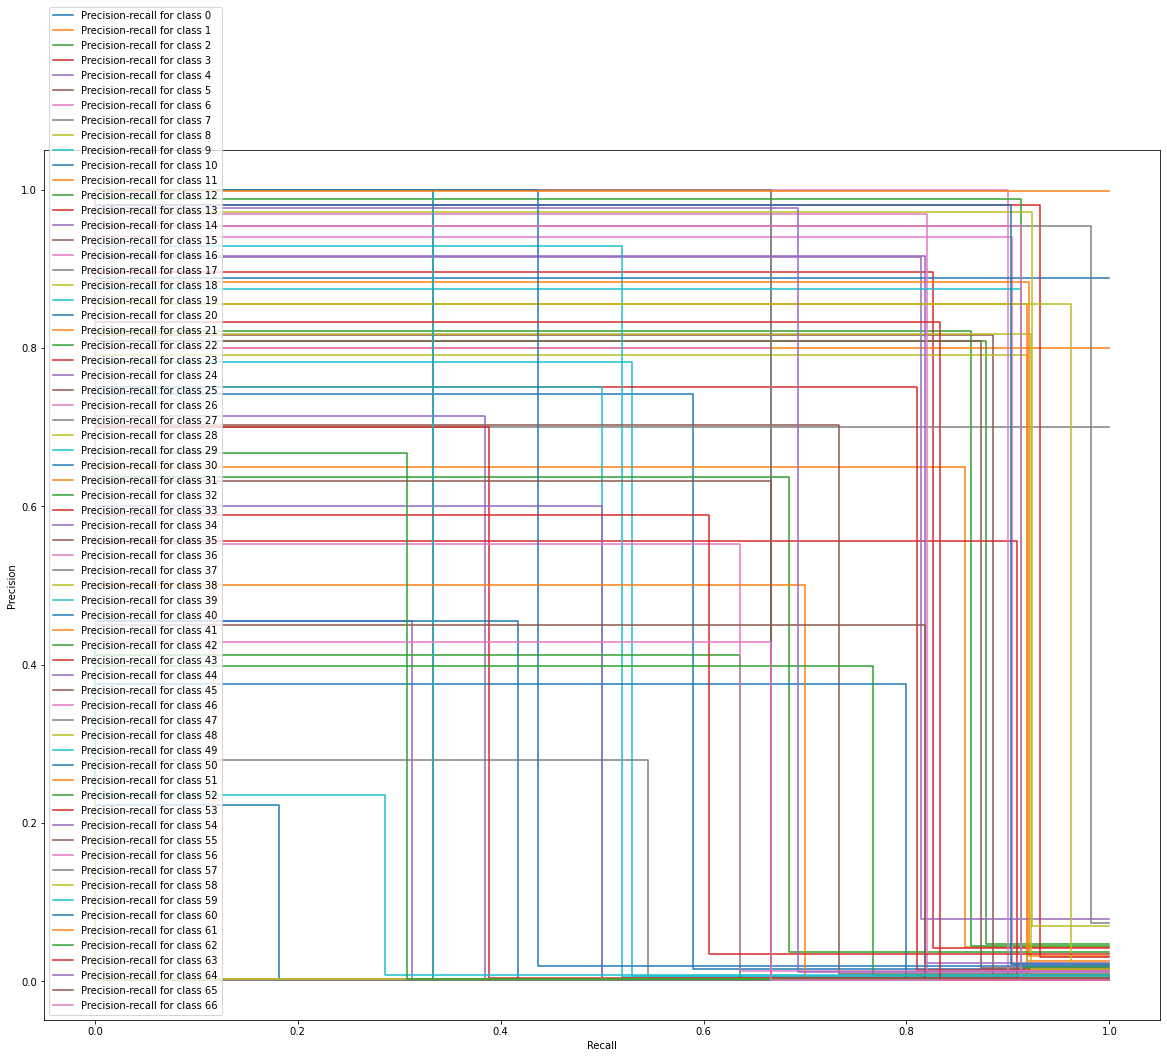

In [27]:
_, ax = plt.subplots(figsize=(20, 16))
for i in range(len(Classes)):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}")
plt.show()

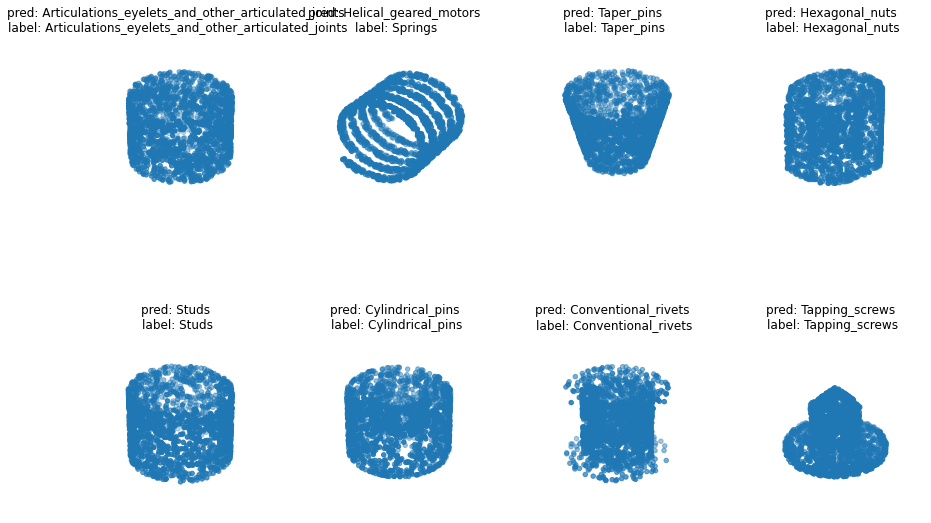

In [32]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:} \nlabel: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.savefig(r'/jet/home/mhrahman/Projects/Project/Pointnet/Figures/Plot_example.jpg', dpi = 300)
plt.show()